# Рост певцов хора
В 1979 году было опрошено 235 членов нью-йоркской ассоциации хорового пения, для каждого из них известен рост и регистр голоса. Меняется ли средний рост вместе с регистром?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
df = pd.read_csv('singers.tsv', sep='\t')
df.head()

,height,voice_part
0,64,Soprano 1
1,62,Soprano 1
2,66,Soprano 1
3,65,Soprano 1
4,60,Soprano 1


In [6]:
df = df.assign(height=df.height * 2.54)

In [7]:
df.head()

,height,voice_part
0,162.56,Soprano 1
1,157.48,Soprano 1
2,167.64,Soprano 1
3,165.10,Soprano 1
4,152.40,Soprano 1


### Визуализируем данные!
Проверим, достаточно ли певцов в каждой группе и есть ли аномалии в выборке

In [8]:
df.voice_part.value_counts()

Bass 1       39
Soprano 1    36
Alto 1       35
Soprano 2    30
Alto 2       27
Bass 2       26
Tenor 2      21
Tenor 1      21
Name: voice_part, dtype: int64

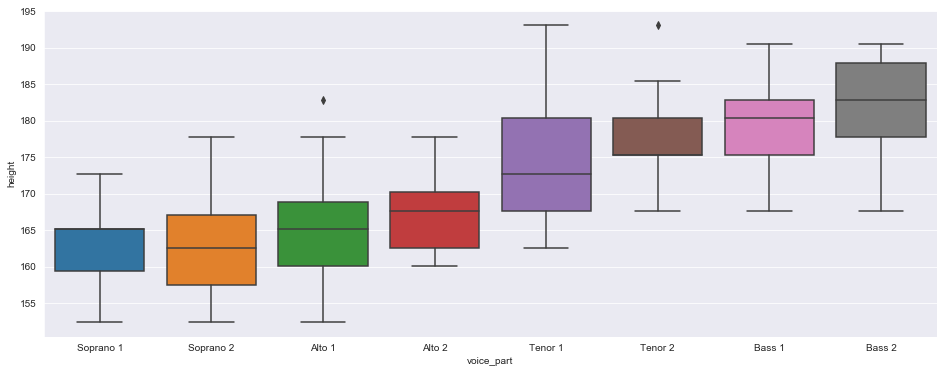

In [9]:
plt.figure(figsize=(16, 6))
sns.boxplot('voice_part',  'height',  data=df)

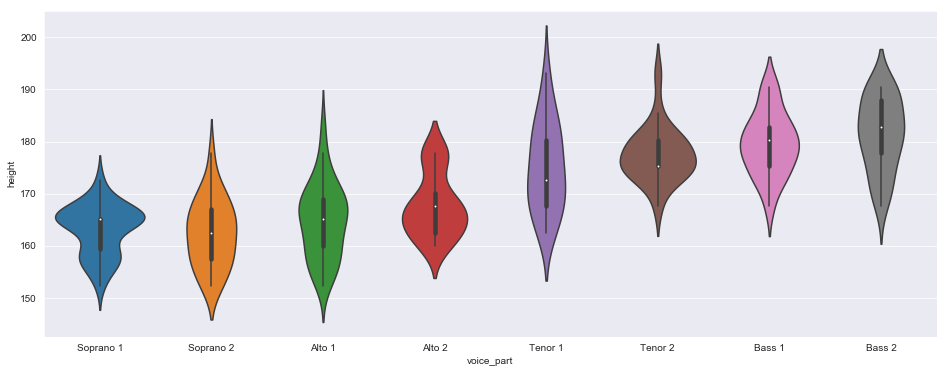

In [10]:
plt.figure(figsize=(16, 6))
sns.violinplot('voice_part',  'height',  data=df)

**Разобьём данные на выборки и проверим гипотезу о равенстве средних при помощи критерия Крускалла-Уоллиса**

In [11]:
heights_groups = list(cur_df.height for _, cur_df in df.groupby('voice_part'))

In [12]:
from scipy.stats import kruskal
kruskal(*heights_groups)

KruskalResult(statistic=141.8362211682088, pvalue=2.095721187194668e-27)

**Гипотетза о равенстве средних во всех группах отвергается. Можно ли воспользоваться более точным критерием Фишера? Проверим равенство дисперсий**

In [13]:
from scipy.stats import bartlett
bartlett(*heights_groups)

BartlettResult(statistic=11.736455812487739, pvalue=0.10956559358742156)

**Да. Критерий Фишера**

In [15]:
from scipy.stats import f_oneway
f_oneway(*heights_groups)

F_onewayResult(statistic=45.6418910588508, pvalue=5.617049546739561e-40)

**Для оценки эффекта воспользуемся реализацией ANOVA из пакета `statsmodels`.**

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('height ~ C(voice_part)', data=df).fit()
aov = anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
C(voice_part),7.0,12911.303982,1844.471997,45.641891,5.617050e-40
Residual,227.0,9173.483695,40.411822,NaN,NaN


**Посчитаем коэффициент $\eta^2$**

In [20]:
aov['eta_sq'] = aov[:-1]['sum_sq'] / aov['sum_sq'].sum()
aov

,df,sum_sq,mean_sq,F,PR(>F),eta_sq
C(voice_part),7.0,12911.303982,1844.471997,45.641891,5.617050e-40,0.584624
Residual,227.0,9173.483695,40.411822,NaN,NaN,NaN


**Средние значения в группах**

In [27]:
cur_df.mean()

height    164.809714
dtype: float64

In [35]:
for voice_part, cur_df in df.groupby('voice_part'):
    print('{:>10}:\tAverage height: {:.2f}'.format(voice_part, cur_df['height'].mean()))

    Alto 1:	Average height: 164.81
    Alto 2:	Average height: 167.73
    Bass 1:	Average height: 179.62
    Bass 2:	Average height: 181.32
 Soprano 1:	Average height: 163.20
 Soprano 2:	Average height: 162.48
   Tenor 1:	Average height: 175.02
   Tenor 2:	Average height: 177.56


In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['height'], df['voice_part'])
mc_results = mc.tukeyhsd()

print(mc_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
   Alto 1    Alto 2   2.9244 0.6065  -2.0572   7.9059  False
   Alto 1    Bass 1  14.8139  0.001  10.2856  19.3422   True
   Alto 1    Bass 2  16.5072  0.001  11.4718  21.5426   True
   Alto 1 Soprano 1  -1.6147    0.9  -6.2314    3.002  False
   Alto 1 Soprano 2  -2.3344 0.7959  -7.1733   2.5046  False
   Alto 1   Tenor 1  10.2084  0.001   4.8401  15.5767   True
   Alto 1   Tenor 2  12.7484  0.001   7.3801  18.1167   True
   Alto 2    Bass 1  11.8895  0.001   7.0205  16.7586   True
   Alto 2    Bass 2  13.5828  0.001    8.239  18.9267   True
   Alto 2 Soprano 1  -4.5391 0.0989  -9.4904   0.4123  False
   Alto 2 Soprano 2  -5.2587 0.0423 -10.4179  -0.0995   True
   Alto 2   Tenor 1    7.284 0.0027   1.6253  12.9427   True
   Alto 2   Tenor 2    9.824  0.001   4.1653  15.4827   True
   Bass 1    Bass 2   1.

### Вывод
Регистр голоса действительно статистически связан с высотой певца и объясняет 58% дисперсии в выборке.  
Средний рост певцов по типу голоса: 

* Alto 1: 164.81см
* Alto 2: 167.73см
* Bass 1: 179.62см
* Bass 2: 181.32см
* Soprano 1: 163.20см
* Soprano 2: 162.48см
* Tenor 1: 175.02см
* Tenor 2: 177.56см